$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\piv}{\mathbf{\pi}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\Sv}{\mathbf{S}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Norm}{\mathcal{N}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

## Research Questions

1) Does the difference between how much a presidential or US senate candidate raises vs their opponent tend to be larger or smaller when the race is against an incumbent vs when the race is between 2 non-incumbents?

  - Does being an incumbent amplify the impact of campaign spending?

2) How well does a logistic regression model that only controls for how much a campaign raises and whether they are an incumbent or not do to predict whether a presidential or US senate candidate will win?


## Presidential Data

### Election and Top-Level Finance Data

All US Presidential data used for the study was consolidated into a single tab delimited file named <span style="color:red; font-weight: bold">USPresidentialOverall.tsv</span>.  The first 8 columns of this spreadhseet were manually scraped from [from the FEC website](https://www.fec.gov/data/raising-bythenumbers/).  The data for the popular vote totals (columns I and J in ) were obtained [from the britannica.com website](https://www.britannica.com/topic/United-States-Presidential-Election-Results-1788863).

The file can be found in my git repo [here](https://raw.githubusercontent.com/MichaelSzczepaniak/CampaignFinance/master/data/USPresidentialOverall.tsv).

## Senate Data

### Historical Senate Election Results

Data for the historical US Senate races was obtained from the [MIT Election Data Science Lab](http://electionlab.mit.edu/) using the interface hosted by [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU)

This study will only focus on top 2 candidates in presidential election years.  To ensure I was able to look at each senate race as essentially between 2 candidates, a couple of unusual races needed to be dealt with.  These two races are described below.

**[1984 Louisiana US Senate race](https://en.wikipedia.org/wiki/1984_United_States_Senate_election_in_Louisiana)** - Only a primary was held in the state.  Democratic incumbent Senator J. Bennett Johnston won the election with 85% of the vote and was declared elected by a majority, dispelling the need for a general election in November.  Data did not include the Republican challenger Robert M. Ross.  This name was manually inserted into the <span style="color:red">1980-2016-SenateElections.csv</span> file along with the <span style="color:red; font-weight: bold">primary</span> vote totals since there was no general election.

**[2004 Idaho US senate race](https://en.wikipedia.org/wiki/2004_United_States_Senate_election_in_Idaho)**  Data did not include the write-in democratic challenger Scott McClure.  This name and vote total was manually inserted into the <span style="color:red">1980-2016-SenateElections.csv</span> file.

### Historical Senate Campaign Financials

Headers for the senate financial data are described here:

https://www.fec.gov/campaign-finance-data/current-campaigns-house-and-senate-file-description/

Data for each US Senate race is in separate files downloaded from the FEC site.  The name of each file follows the format `weballyyyy.txt` where `yyyy` is the year.  These files are pipe (|) delimited.

These individual files are read and concatinated together before additional wrangling is done on them.

## Data Paths

The next cells creates paths to various data files used in the study.

In [1]:
import numpy as np
import pandas as pd

notebook_start_dir = './'  #'./Week09_10_FinalProject/'

pres_dir = notebook_start_dir + 'datasets/presidential/'
senate_dir = notebook_start_dir + 'datasets/senate/'

# presidential election and top-level finance data - 10 records, manually compiled
pres_overall_path = pres_dir + 'USPresidentialOverall.tsv'

# senate election data
senate_elecs_path = senate_dir + '1980-2016-SenateElections.csv'

In [2]:
# senate finance data
pres_elect_years = list(range(1980, 2018, 4))
sen_fin_dirs = ['web' + str(year) for year in pres_elect_years]
# build the file names
sen_fin_file_names = ['weball' + yr[-2:] + '.txt' for yr in sen_fin_dirs]
# build the file paths
sen_fin_file_paths = [d + '/' + n for d,n in dict(zip(sen_fin_dirs, sen_fin_file_names)).items()]
sen_fin_file_paths = [senate_dir + sen_path for sen_path in sen_fin_file_paths]
sen_fin_file_paths

['./datasets/senate/web1980/weball80.txt',
 './datasets/senate/web1984/weball84.txt',
 './datasets/senate/web1988/weball88.txt',
 './datasets/senate/web1992/weball92.txt',
 './datasets/senate/web1996/weball96.txt',
 './datasets/senate/web2000/weball00.txt',
 './datasets/senate/web2004/weball04.txt',
 './datasets/senate/web2008/weball08.txt',
 './datasets/senate/web2012/weball12.txt',
 './datasets/senate/web2016/weball16.txt']

### Process Historical US Senate Election Results

The next cell filters out all but the top two contenders in each US Senate race

In [3]:
# sort the senate election data by year ASC, state ASC and votes DSC to make it easier
# to filter out all but the top 2 vote getters in each election
df_senate_elecs = pd.read_csv(senate_elecs_path).sort_values(by=['year', 'state', 'candidatevotes'],
                                                             ascending=[True, True, False])
# SQL Server ROW_NUMBER() window function equivalent
df_senate_elecs['rank'] = \
  df_senate_elecs.groupby(['year', 'state'])['candidatevotes'].rank(method='first',
                                                                    ascending=False).astype(int)
df_sen_elec = df_senate_elecs.loc[df_senate_elecs['rank'] <= 2, :].copy()

df_senate_elecs.shape, df_sen_elec.shape  # removes a litte under 60% of the records

((2985, 19), (1277, 19))

Create the column that indicates who won the election and rename some columns to make make joining the election results data to the campaign finance data easier.  Then filter out non-presidential election years.

In [4]:
# convert rank column to Won
df_sen_elec.rename(columns={'rank': "Won"}, inplace=True)
df_sen_elec.loc[df_sen_elec['Won'] == 2, 'Won'] = 0

# get grab columns we need
needed_cols = ['year', 'state', 'state_po', 'candidate', 'party', 'candidatevotes', 'totalvotes', 'Won']
df_sen_elec = df_sen_elec.loc[:, needed_cols]

# party will be one common field to join to finanacial df
df_sen_elec['CAND_PTY_AFFILIATION'] = df_sen_elec['party'].str.upper()
df_sen_elec['CAND_PTY_AFFILIATION'] = df_sen_elec.loc[:, 'CAND_PTY_AFFILIATION'].str[:3]

# change col names to ease joining to finance data
df_sen_elec.rename(columns={'state': 'state_name', 'state_po': 'state',
                            'party': 'party_name', 'CAND_PTY_AFFILIATION': 'party'}, inplace=True)

In [5]:
# df_sen_elec.shape  # (1276, 9) before filtering out non-presidential election years
df_sen_elec_pres_yrs = df_sen_elec.loc[df_sen_elec['year'].isin(pres_elect_years)]
df_sen_elec_pres_yrs.shape, df_sen_elec_pres_yrs['year'].unique(), df_sen_elec_pres_yrs.head(4)

((667, 9), array([1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016],
       dtype=int64),    year state_name state           candidate  party_name  candidatevotes  \
 0  1980    Alabama    AL     Jeremiah Denton  republican          650362   
 1  1980    Alabama    AL      Jim Folsom Jr.    democrat          610175   
 2  1980     Alaska    AK  Frank H. Murkowski  republican           84159   
 3  1980     Alaska    AK   Clark S. Gruening    democrat           72007   
 
    totalvotes  Won party  
 0     1296757    1   REP  
 1     1296757    0   DEM  
 2      156762    1   REP  
 3      156762    0   DEM  )

### Joining Historical Senate Elections Data With Historical Senate Finance Data

The campaign finance data typically lists more than 2 candidates for each race, so in order to join the election results and campaign finance data, 4 fields are used:

  + `year` the election year
  + `state` the state seat the senate race was for
  + `party` the party of the candidates
  + `LastName` the last name of each candidate

Before working on the campaign financial data, the election data needed some additional cleaning in order to create the `LastName` column.

In [6]:
df_sen_elec = df_sen_elec_pres_yrs.copy()
# last name of candidate will be another field used to join to financial df
# need to do some wrangling to remove things like: Jr., Sr., III, IV
name_tails = [', Jr.', ' Jr.', ', Sr.', ' Sr.', ' III', ' IV']
df_sen_elec['StripName'] = df_sen_elec['candidate'].str.replace(name_tails[0], '')
# trim trailing white space
df_sen_elec['StripName'] = df_sen_elec['StripName'].str.strip()
# create an intermediate column with the Jr, Sr etc stuff stripped out
for i in range(1, len(name_tails)):
    df_sen_elec['StripName'] = df_sen_elec['StripName'].str.replace(name_tails[i], '')
# finally, extract the last name from stripped name to form the LastName column
df_sen_elec['LastName'] = df_sen_elec['StripName'].str.extract(r'\b(\w+)$', expand=True)
df_sen_elec['LastName'] = df_sen_elec['LastName'].str.upper()

pd.concat([df_sen_elec.head(), df_sen_elec.tail()])

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER
2971,2016,Vermont,VT,Scott Milne,republican,103637,320467,0,REP,Scott Milne,MILNE
2978,2016,Washington,WA,Patty Murray,democrat,1913979,3243317,1,DEM,Patty Murray,MURRAY
2979,2016,Washington,WA,Chris Vance,republican,1329338,3243317,0,REP,Chris Vance,VANCE
2980,2016,Wisconsin,WI,Ron Johnson,republican,1479471,2948741,1,REP,Ron Johnson,JOHNSON
2981,2016,Wisconsin,WI,Russ Feingold,democrat,1380335,2948741,0,DEM,Russ Feingold,FEINGOLD


In [7]:
df_sen_elec.to_csv(senate_dir + 'df_sen_elec.csv', index=False)  # write to file for back up

### Process Historical US Senate Campaign Financial Results

The next cells reads the file names generate in cell 2, appends the results together and then attached the column name headers.

In [8]:
pres_elect_years

[1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016]

In [9]:
# read the first file and then append data for the later years
df_sen_fin = pd.read_csv(sen_fin_file_paths[0], sep='|', header = None)
df_sen_fin['year'] = pres_elect_years[0]
df_sen_fin.head(3)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,year
0,H0AK00014,"WHITTAKER, RICHARD",NaN,1,DEM,1116,0,764,0,0,...,L,NaN,L,0.0,0,0,10/15/1980,0,0,1980
1,H0AK01012,"PARNELL, KEVIN ""PAT""",NaN,1,DEM,51643,0,51607,0,0,...,W,NaN,L,26.0,0,0,12/31/1980,0,0,1980
2,H6AK00029,"HENSLEY, WILLIAM L.",NaN,1,DEM,0,0,0,0,0,...,NaN,NaN,NaN,NaN,0,0,12/31/1980,0,0,1980


In [10]:
for i in range(1, len(sen_fin_file_paths)):
    elec_year = pres_elect_years[i]
    df_temp = pd.read_csv(sen_fin_file_paths[i], sep='|', header=None)
    df_temp['year'] = elec_year
    df_sen_fin = pd.concat([df_sen_fin, df_temp])
    print(df_sen_fin.shape)

# add the column headers
senate_finance_headers = ['CAND_ID', 'CAND_NAME', 'CAND_ICI', 'PTY_CD', 'CAND_PTY_AFFILIATION',
                          'TTL_RECEIPTS', 'TRANS_FROM_AUTH', 'TTL_DISB', 'TRANS_TO_AUTH',
                          'COH_BOP', 'COH_COP', 'CAND_CONTRIB', 'CAND_LOANS', 'OTHER_LOANS',
                          'CAND_LOAN_REPAY', 'OTHER_LOAN_REPAY', 'DEBTS_OWED_BY', 'TTL_INDIV_CONTRIB',
                          'CAND_OFFICE_ST', 'CAND_OFFICE_DISTRICT', 'SPEC_ELECTION', 'PRIM_ELECTION',
                          'RUN_ELECTION', 'GEN_ELECTION', 'GEN_ELECTION_PRECENT', 'OTHER_POL_CMTE_CONTRIB',
                          'POL_PTY_CONTRIB', 'CVG_END_DT', 'INDIV_REFUNDS', 'CMTE_REFUNDS', 'year']    
df_sen_fin.columns = senate_finance_headers
pd.concat([df_sen_fin.head(3), df_sen_fin.tail(3)])

(4732, 31)
(7015, 31)
(10031, 31)
(13076, 31)
(15680, 31)
(18148, 31)
(20748, 31)
(24019, 31)
(25917, 31)


,CAND_ID,CAND_NAME,CAND_ICI,PTY_CD,CAND_PTY_AFFILIATION,TTL_RECEIPTS,TRANS_FROM_AUTH,TTL_DISB,TRANS_TO_AUTH,COH_BOP,...,PRIM_ELECTION,RUN_ELECTION,GEN_ELECTION,GEN_ELECTION_PRECENT,OTHER_POL_CMTE_CONTRIB,POL_PTY_CONTRIB,CVG_END_DT,INDIV_REFUNDS,CMTE_REFUNDS,year
0,H0AK00014,"WHITTAKER, RICHARD",NaN,1,DEM,1116.00,0.00,764.00,0.0,0.0,...,L,NaN,L,0.0,0.00,0.0,10/15/1980,0.0,0.00,1980
1,H0AK01012,"PARNELL, KEVIN ""PAT""",NaN,1,DEM,51643.00,0.00,51607.00,0.0,0.0,...,W,NaN,L,26.0,0.00,0.0,12/31/1980,0.0,0.00,1980
2,H6AK00029,"HENSLEY, WILLIAM L.",NaN,1,DEM,0.00,0.00,0.00,0.0,0.0,...,NaN,NaN,NaN,NaN,0.00,0.0,12/31/1980,0.0,0.00,1980
1895,S8WI00026,"FEINGOLD, RUSSELL DANA",C,1,DEM,24857171.00,566291.00,24796275.00,0.0,0.0,...,NaN,NaN,NaN,NaN,1031924.00,46800.0,12/31/2016,250853.0,1057.00,2016
1896,S0WI00197,"JOHNSON, RONALD HAROLD",I,2,REP,17683385.71,391901.85,18245101.44,0.0,605977.0,...,NaN,NaN,NaN,NaN,2219078.23,51800.0,12/31/2016,235544.0,52375.88,2016
1897,S6WI00152,"ANDERSON, PHILLIP NORMAN",C,3,LIB,10948.00,0.00,5181.00,0.0,295.0,...,NaN,NaN,NaN,NaN,0.00,0.0,10/01/2016,0.0,0.00,2016


In [11]:
# house candidate id's start with H, senate candidates id's start with S 
df_sen_fin = df_sen_fin.loc[df_sen_fin['CAND_ID'].str.startswith("S")]  # (25917, 30) before filter applied
df_sen_fin.shape

(4093, 31)

In [12]:
# only need these fields
needed_cols = ['CAND_OFFICE_ST', 'CAND_NAME', 'CAND_ICI', 'CAND_PTY_AFFILIATION', 'TTL_RECEIPTS', 'year']
df_sen_fin = df_sen_fin.loc[:, needed_cols]
# align finance column names with election results column names
df_sen_fin.rename(columns={'CAND_OFFICE_ST': 'state', 'CAND_PTY_AFFILIATION': 'party'}, inplace=True)


# http://www.datasciencemadesimple.com/extract-substring-from-column-in-pandas-python-2/
# NOTE: The CAND_NAME field starts with the last name in this file, so extracting
#       them is simplier than it was for the election data
df_sen_fin['LastName'] = df_sen_fin['CAND_NAME'].str.extract(r'^(\w+),', expand=True)

In [13]:
# df_sen_fin.tail(5)
df_sen_fin.shape, df_sen_fin.shape, df_sen_fin.head(10)

((4093, 7),
 (4093, 7),
      state              CAND_NAME CAND_ICI party  TTL_RECEIPTS  year  \
 2056    AK        GRUENING, CLARK      NaN   DEM      512411.0  1980   
 2057    AK     BEASLEY, MICHAEL J      NaN   DEM        5545.0  1980   
 2058    AK           GRAVEL, MIKE        I   DEM      906175.0  1980   
 2059    AK    HOBBS, DONALD WYLIE      NaN   DEM           0.0  1980   
 2060    AK  KENNEDY, ARTHUR RALPH      NaN   REP       62697.0  1980   
 2061    AK      SMITH, DONALD LEE      NaN   REP         742.0  1980   
 2062    AK       THOMPSON, MORRIS      NaN   REP       65696.0  1980   
 2063    AK     MURKOWSKI, FRANK H      NaN   REP      527206.0  1980   
 2064    AK      MOE, DAVID JEROME      NaN   REP        1800.0  1980   
 2065    AK           STEVENS, TED        I   REP       35706.0  1980   
 
        LastName  
 2056   GRUENING  
 2057    BEASLEY  
 2058     GRAVEL  
 2059      HOBBS  
 2060    KENNEDY  
 2061      SMITH  
 2062   THOMPSON  
 2063  MURKOWSKI  


### Join Election and Campaign Finance Dataframes


In [14]:
df_sen_all = df_sen_elec.merge(df_sen_fin, how='left', on=['year', 'state', 'party', 'LastName'])
df_sen_elec.shape, df_sen_fin.shape, df_sen_all.shape

((667, 11), (4093, 7), (675, 14))

### Quality Check on Merged Data

The`df_sen_fin` dataframe should be much larger than `df_sen_elec` because the former contains the US House of Representative races along with the US Senate races.  However, the `df_sen_all` dataframe should be the same size as `df_sen_fin`.

While going through the `df_sen_all` and `df_sen_fin` dataframes manually, 35 manual changes where made to the `df_sen_all.csv` file.  Each change is described in the file `manual_fixes.txt`.  These changes did not bring these two files into perfect alignment, but they resolve most of the difference.

To replicate the data used in this analysis, all the cells above this one only need to be run once followed by the manual fixes that need to be made and then saved.  From this point forward, the `df_sen_all_manually_fixed.csv` and `USPresidentialOverall.tsv` files are the primary sources of data used for the remainder of this project.

In [15]:
df_sen_fixed = pd.read_csv(senate_dir + 'df_sen_all_manually_fixed.csv')
df_sen_all.shape, df_sen_fixed.shape

((675, 14), (671, 14))

### Presidential Races

From 1980 through 2016, the presidential races were evenly distributed between the following 3 classes:

1. between 2 challengers
2. between a democratic incumbent and republican challenger
3. between a republican incumbent and democratic challenger

In [16]:
df_pres_overall = pd.read_csv(pres_overall_path, sep='\t').sort_values(by=['Year'])
df_pres_overall.set_index('Year', inplace=True)
df_pres_overall.columns

Index(['Candidate1', 'Candidate2', 'Party1', 'Party2', 'Winner',
       'CampaignRaised1', 'CampaignRaised2', 'PopularVote1', 'PopularVote2',
       'Incumbent'],
      dtype='object')

In [17]:
x_ind = np.arange(df_pres_overall.shape[0])  # x locations for the groups
bar_width = 0.35

# If these aren't wrapped by np.array(...), the I get this:
# TypeError: only size-1 arrays can be converted to Python scalars
# when I try to create the bar plot below.  Details of the fix are discussed here:
# https://stackoverflow.com/questions/21687581/
#         typeerror-only-length-1-arrays-can-be-converted-to-python-scalars-while-trying
dem_raise = np.array(df_pres_overall.copy().sort_values(by=['Year'])['CampaignRaised1'] / 1e09)
rep_raise = np.array(df_pres_overall.copy().sort_values(by=['Year'])['CampaignRaised2'] / 1e09)

dem_raise, rep_raise, dem_raise+rep_raise, type(dem_raise), type(rep_raise)

(array([0.01982884, 0.08287973, 0.09009656, 0.11526153, 0.1239358 ,
        0.13310804, 0.35159827, 0.77864296, 0.74260191, 0.58569906]),
 array([0.06294416, 0.07647662, 0.09134961, 0.1019369 , 0.14427092,
        0.19365773, 0.37784644, 0.40153714, 0.4836429 , 0.35066844]),
 array([0.08277301, 0.15935635, 0.18144617, 0.21719844, 0.26820672,
        0.32676577, 0.72944472, 1.1801801 , 1.22624481, 0.9363675 ]),
 numpy.ndarray,
 numpy.ndarray)

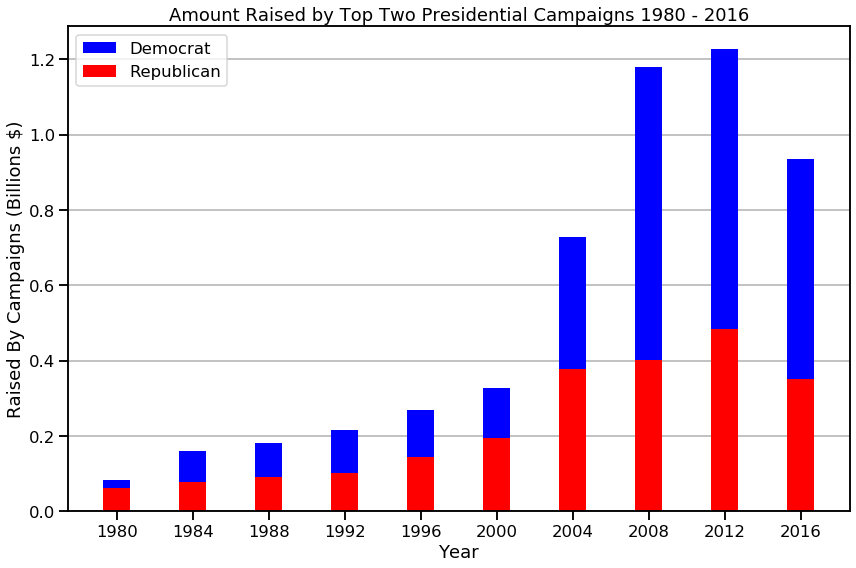

In [18]:
import matplotlib
import matplotlib.pyplot as plt
# Use Seaborn's context settings to make fonts larger (except the wedge label...)
import seaborn as sns
sns.set_context('talk')

%matplotlib inline
# grouped bar charts: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots()
# left_bar = ax.bar(x_ind - bar_width/2, dem_raise, bar_width, label='Democrat')
# right_bar = ax.bar(x_ind + bar_width/2, rep_raise, bar_width, label='Republican')
# dem_bar = ax.bar(x_ind, dem_raise, bar_width,
#                  color='blue', label='Democrat')
dem_bar = ax.bar(x_ind, dem_raise, bar_width,
                 bottom=rep_raise, color='blue', label='Democrat')
rep_bar = ax.bar(x_ind, rep_raise, bar_width,
                 color='red', label='Republican')

ax.set_ylabel('Raised By Campaigns (Billions $)')
ax.set_xlabel('Year')
ax.set_title('Amount Raised by Top Two Presidential Campaigns 1980 - 2016')
ax.set_xticks(x_ind)
ax.set_xticklabels(df_pres_overall.index)
ax.legend(loc="upper left")
ax.grid(axis='y')
ax.set_axisbelow(True)

fig.tight_layout()

plt.show()

In [19]:
df_pres = df_pres_overall.copy()

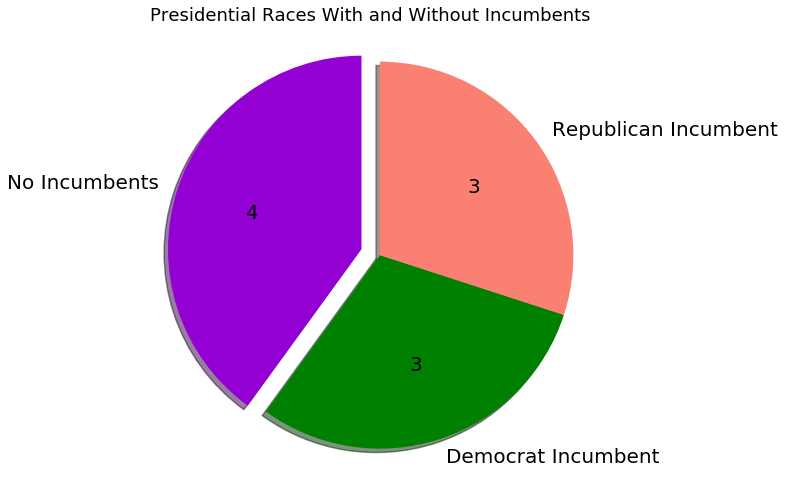

In [20]:
race_types = ["No Incumbents", "Democrat Incumbent", "Republican Incumbent"]
count_no_incumbs = df_pres.loc[df_pres['Incumbent'] == 0].shape[0]
count_dem_incumbs = df_pres.loc[df_pres['Incumbent'] == 1].shape[0]
count_rep_incumbs = df_pres.loc[df_pres['Incumbent'] == 2].shape[0]
race_counts = [count_no_incumbs, count_dem_incumbs, count_rep_incumbs]
# race_count_str = [str(count_dem_incumbs), str(count_rep_incumbs), str(count_no_incumbs)]

def func(lab):
    return str(round((lab/10), 0).astype(int))

fig_pie, ax_pie = plt.subplots(figsize=(12,8))
ax_pie.pie(race_counts, explode=(0.1,0,0), labels=race_types,
           colors=['darkviolet', 'green', 'salmon'],
           autopct=lambda x: func(x),
# https://stackoverflow.com/questions/7082345/how-to-set-the-labels-size-on-a-pie-chart-in-python
           textprops={'fontsize': 20},
           shadow=True, startangle=90)
ax_pie.axis('equal')
plt.title("Presidential Races With and Without Incumbents", pad=15)

# increase the font size of wedge labels
# https://stackoverflow.com/questions/55161508/increase-font-size-of-labels-in-pie-chart-matplotlib
# matplotlib.rcParams.update({'font.size': 40})
# matplotlib.rcParams['font.size'] = 40.0
# plt.rcParams['font.size'] = 40

plt.show()

### What Campaigns Raised Per Voter

In an attempt to keep the numbers in perspective, the amounts a candidate raised will be divided by the number of votes recieved by that candidate.

### Presidential Races Without an Incumbent

In [21]:
df_pres_no_inc = df_pres.copy().loc[df_pres['Incumbent'] == 0, :]
df_pres_no_inc['RaisePerVote1'] = df_pres_no_inc['CampaignRaised1'] / df_pres_no_inc['PopularVote1']
df_pres_no_inc['RaisePerVote2'] = df_pres_no_inc['CampaignRaised2'] / df_pres_no_inc['PopularVote2']
df_pres_no_inc

,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
Year,,,,,,,,,,,,
1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,9.009656e+07,9.134962e+07,41809074,48886097,0,2.154952,1.868622
2000,Gore A,Bush GW,Democrat,Republican,Bush GW,1.331080e+08,1.936577e+08,50999897,50456002,0,2.609967,3.838150
2008,Obama B,McCain J,Democrat,Republican,Obama B,7.786430e+08,4.015371e+08,69456000,59934000,0,11.210593,6.699655
2016,Clinton H,Trump D,Democrat,Republican,Trump D,5.856991e+08,3.506684e+08,65844610,62979636,0,8.895171,5.567965


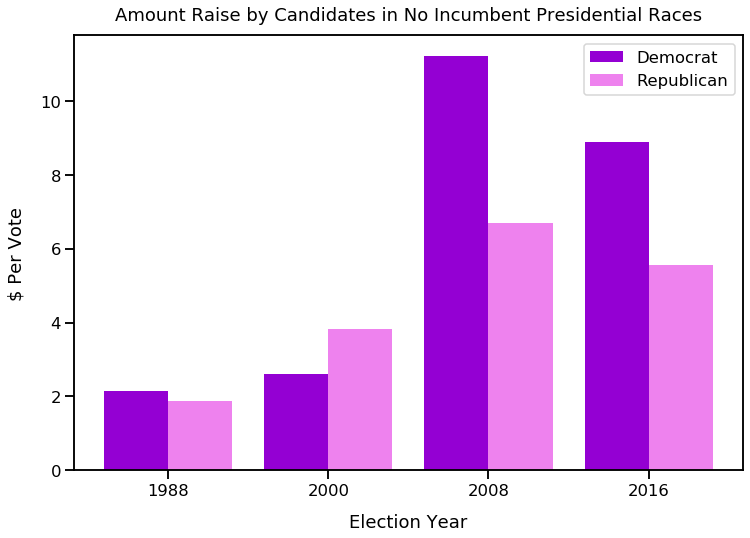

In [22]:
# https://www.pythoncharts.com/2019/03/26/grouped-bar-charts-matplotlib/
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_no_inc.index.unique()))

b1 = ax.bar(x, df_pres_no_inc['RaisePerVote1'], width=bar_width, color='darkviolet', label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_no_inc['RaisePerVote2'], width=bar_width,
            color='violet', label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_no_inc.index.unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in No Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Races With Democrat Incumbent

In [23]:
df_pres_dem_inc = df_pres.copy().loc[df_pres['Incumbent'] == 1, :]
df_pres_dem_inc['RaisePerVote1'] = df_pres_dem_inc['CampaignRaised1'] / df_pres_dem_inc['PopularVote1']
df_pres_dem_inc['RaisePerVote2'] = df_pres_dem_inc['CampaignRaised2'] / df_pres_dem_inc['PopularVote2']
df_pres_dem_inc

,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
Year,,,,,,,,,,,,
1980,Carter J,Reagan R,Democrat,Republican,Reagan R,1.982884e+07,6.294416e+07,35480948,43642639,1,0.558859,1.442263
1996,Clinton W,Dole R,Democrat,Republican,Clinton W,1.239358e+08,1.442709e+08,47402357,39198755,1,2.614549,3.680498
2012,Obama B,Romney M,Democrat,Republican,Obama B,7.426019e+08,4.836429e+08,65446032,60589084,1,11.346783,7.982344


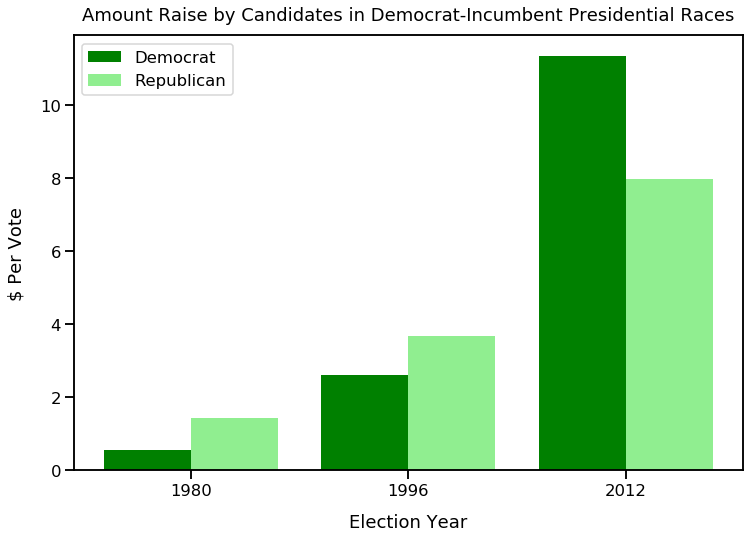

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_dem_inc.index.unique()))

b1 = ax.bar(x, df_pres_dem_inc['RaisePerVote1'], width=bar_width, color='green', label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_dem_inc['RaisePerVote2'], width=bar_width,
            color='lightgreen', label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_dem_inc.index.unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in Democrat-Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Races With Republican Incumbent

In [25]:
df_pres_rep_inc = df_pres.copy().loc[df_pres['Incumbent'] == 2, :]
df_pres_rep_inc['RaisePerVote1'] = df_pres_rep_inc['CampaignRaised1'] / df_pres_rep_inc['PopularVote1']
df_pres_rep_inc['RaisePerVote2'] = df_pres_rep_inc['CampaignRaised2'] / df_pres_rep_inc['PopularVote2']
df_pres_rep_inc

,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,RaisePerVote1,RaisePerVote2
Year,,,,,,,,,,,,
1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,8.287973e+07,7.647662e+07,37577185,54455075,2,2.205586,1.404398
1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,1.152615e+08,1.019369e+08,44909889,39104545,2,2.566507,2.606779
2004,Kerry J,Bush GW,Democrat,Republican,Bush GW,3.515983e+08,3.778464e+08,59028109,62028285,2,5.956455,6.091518


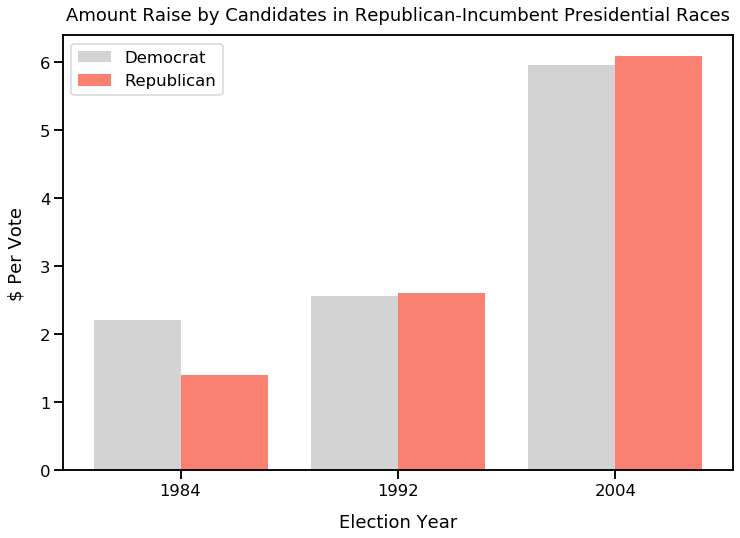

In [26]:
fig, ax = plt.subplots(figsize=(12,8))

bar_width = 0.4
x = np.arange(len(df_pres_rep_inc.index.unique()))

b1 = ax.bar(x, df_pres_rep_inc['RaisePerVote1'], width=bar_width, color='lightgrey', label="Democrat")
b2 = ax.bar(x + bar_width, df_pres_rep_inc['RaisePerVote2'], width=bar_width,
            color='salmon', label="Republican")
# set the x-axis labels to the year of the election
ax.set_xticks(x + bar_width / 2)  # so labels are in the center of the grouping
ax.set_xticklabels(df_pres_rep_inc.index.unique())

ax.legend()

ax.set_xlabel("Election Year", labelpad=15)
ax.set_ylabel("$ Per Vote", labelpad=15)
ax.set_title("Amount Raise by Candidates in Republican-Incumbent Presidential Races", pad=15)

plt.show()

### Presidential Difference Between Winner and Loser

In [27]:
df_pres['candidate1_win'] = (df_pres['Winner'] == df_pres['Candidate1']).astype(int)
df_pres['winner1_raised'] = df_pres['candidate1_win'] * df_pres['CampaignRaised1']
df_pres['winner2_raised'] = (~(df_pres['candidate1_win'].astype(bool))).astype(int) * \
                             df_pres['CampaignRaised2']
df_pres['winner_raised'] = df_pres['winner1_raised'] + df_pres['winner2_raised']
df_pres['loser_raised'] = df_pres['CampaignRaised1'] + df_pres['CampaignRaised2'] - \
                          df_pres['winner_raised']
# compute difference between what winner raise and loser raise
df_pres['raised_diff'] = (df_pres['winner_raised'] - df_pres['loser_raised']) / df_pres['winner_raised']
# compute the winning vote margin
df_pres['winner_vote_margin'] = (df_pres['PopularVote1'] - df_pres['PopularVote2']).abs()
# compute winner raised per winning vote margin
df_pres['diff_winner_loser_per_vote'] = df_pres['raised_diff'] / df_pres['winner_vote_margin']
df_pres

,Candidate1,Candidate2,Party1,Party2,Winner,CampaignRaised1,CampaignRaised2,PopularVote1,PopularVote2,Incumbent,candidate1_win,winner1_raised,winner2_raised,winner_raised,loser_raised,raised_diff,winner_vote_margin,diff_winner_loser_per_vote
Year,,,,,,,,,,,,,,,,,,
1980,Carter J,Reagan R,Democrat,Republican,Reagan R,1.982884e+07,6.294416e+07,35480948,43642639,1,0,0.000000e+00,6.294416e+07,6.294416e+07,1.982884e+07,0.684977,8161691,8.392590e-08
1984,Mondale W,Reagan R,Democrat,Republican,Reagan R,8.287973e+07,7.647662e+07,37577185,54455075,2,0,0.000000e+00,7.647662e+07,7.647662e+07,8.287973e+07,-0.083726,16877890,-4.960713e-09
1988,Dukakis M,Bush GH,Democrat,Republican,Bush GH,9.009656e+07,9.134962e+07,41809074,48886097,0,0,0.000000e+00,9.134962e+07,9.134962e+07,9.009656e+07,0.013717,7077023,1.938268e-09
1992,Clinton W,Bush GH,Democrat,Republican,Clinton W,1.152615e+08,1.019369e+08,44909889,39104545,2,1,1.152615e+08,0.000000e+00,1.152615e+08,1.019369e+08,0.115603,5805344,1.991328e-08
1996,Clinton W,Dole R,Democrat,Republican,Clinton W,1.239358e+08,1.442709e+08,47402357,39198755,1,1,1.239358e+08,0.000000e+00,1.239358e+08,1.442709e+08,-0.164078,8203602,-2.000071e-08
2000,Gore A,Bush GW,Democrat,Republican,Bush GW,1.331080e+08,1.936577e+08,50999897,50456002,0,0,0.000000e+00,1.936577e+08,1.936577e+08,1.331080e+08,0.312663,543895,5.748599e-07
2004,Kerry J,Bush GW,Democrat,Republican,Bush GW,3.515983e+08,3.778464e+08,59028109,62028285,2,0,0.000000e+00,3.778464e+08,3.778464e+08,3.515983e+08,0.069468,3000176,2.315458e-08
2008,Obama B,McCain J,Democrat,Republican,Obama B,7.786430e+08,4.015371e+08,69456000,59934000,0,1,7.786430e+08,0.000000e+00,7.786430e+08,4.015371e+08,0.484312,9522000,5.086238e-08
2012,Obama B,Romney M,Democrat,Republican,Obama B,7.426019e+08,4.836429e+08,65446032,60589084,1,1,7.426019e+08,0.000000e+00,7.426019e+08,4.836429e+08,0.348718,4856948,7.179786e-08


In [28]:
years = df_pres.index.sort_values().astype(str).tolist()
years

['1980',
 '1984',
 '1988',
 '1992',
 '1996',
 '2000',
 '2004',
 '2008',
 '2012',
 '2016']

In [29]:
election_anns = ['Reagan beats Carter (I)', 'Reagan (I) beats Mondale', 'Bush beats Dukakis',
                 'Clinton beats Bush (I)', 'Clinton (I) beats Dole',' Bush beats Gore',
                 'Bush (I) beats Kerry', 'Obama beats McCain',
                 'Obama (I) beats Romney','Trump beats Clinton']
ann_colors = ['white','black','black',
              'black','black','black',
              'black','black','black','white']
# location of the text annotating each bar: center = center of the bar with white text
# above = above the y = 0
ann_locs = ['center','above','below','below','above','below','below','below','below','center']

def get_valign(y_val, h_val, ind, va_val, y_spacer = 0.05):
    """
    
    """
    ret_val = y_val + h_val/2
    if(ind == 0 or ind == 10):
        return (ret_val, va_val)
    else:
        if(va_val == 'above'):
            return (y_spacer, 'bottom')
        else:
            return (-y_spacer, 'top')
    
    

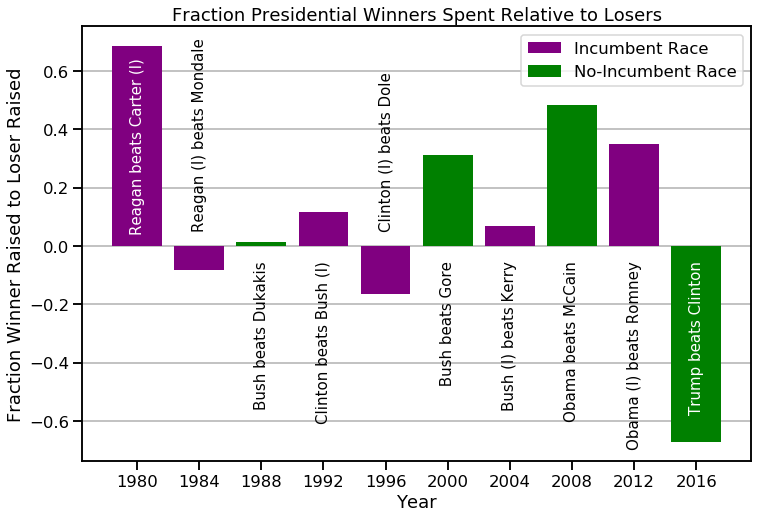

In [30]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12,8))

bar_colors = ['purple','purple','green','purple','purple',
              'green','purple','green','purple','green']
ax.bar(years, df_pres['raised_diff'], color=bar_colors)
ax.set_title("Fraction Presidential Winners Spent Relative to Losers")
ax.set_ylabel("Fraction Winner Raised to Loser Raised")
ax.set_xlabel("Year")
ax.grid(axis='y')
ax.set_axisbelow(True)  # puts the grid in the background
# add labels to see who was running each election year
for i in range(len(ax.patches)):
    p = ax.patches[i]
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()  # bottom left x and y coord's 
    y_text_base = get_valign(y, height, i, ann_locs[i])[0]
    y_text_align = get_valign(y, height, i, ann_locs[i])[1]
    ax.text(x=x+width/2,
            y=y_text_base,  #y+height/2,
            s=election_anns[i],
            horizontalalignment='center',
            verticalalignment=y_text_align,
            color=ann_colors[i],
            rotation=90,
            size=15
           )
legend_elements = [Patch(facecolor='purple', label='Incumbent Race'),
                   Patch(facecolor='green', label='No-Incumbent Race')]

ax.legend(handles=legend_elements)
    
plt.show()

### Presidential Winner Spending Vs. Losers

In the last 10 presidential elections from 1980 through 2016:

+ Winning presidential candidate outspend losers 7 out of those 10 elections (bars going up above 0)
+ Of the 7 races where the winner outspent the loser: 
  - 3 were no-incumbent races and 4 were against and incumbent.
+ Of the 3 races where the loser outspent the winner (bars going down below 0):
  - 1 was a no-incumbent race and 2 were against an incumbent.

It's not clear if there is a relationship between how much a winner outspends their opponent in an incumbent vs a no-incumbent race.  Let's take a look at some averages.

In [31]:
incumb_races = df_pres.copy().loc[df_pres['Incumbent'] > 0]
no_incumb_races = df_pres.copy().loc[df_pres['Incumbent'] == 0]
mean_incumb_outspend = incumb_races['raised_diff'].mean()
mean_no_incumb_outspend = no_incumb_races['raised_diff'].mean()

incumb_races.shape, no_incumb_races.shape, \
round(100. * mean_incumb_outspend, 2), round(100. * mean_no_incumb_outspend, 2)

((6, 18), (4, 18), 16.18, 3.51)

### Incumbent Winners Outspend Their Challengers On Average

Incumbent winners outspend their opponents on average of 16.2% compared to no-incumbent winners who outspent their opponents on average 3.5%.  The means are shown as white diamonds in the chart below.

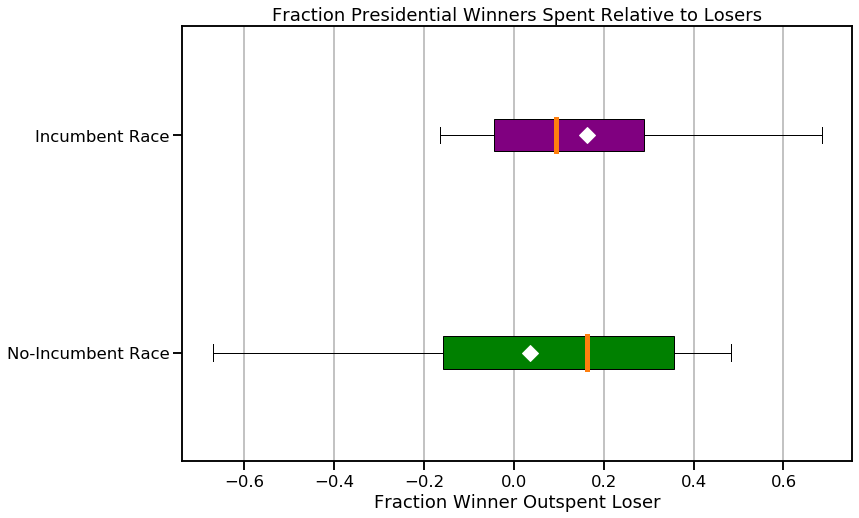

In [32]:
won_1_inc = np.array(incumb_races['raised_diff'])
won_0_inc = np.array(no_incumb_races['raised_diff'])
                     
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([won_0_inc, won_1_inc],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['No-Incumbent Race', 'Incumbent Race'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)

box['boxes'][0].set_facecolor('green')
box['boxes'][1].set_facecolor('purple')

ax.set_xlabel('Fraction Winner Outspent Loser')
ax.set_title('Fraction Presidential Winners Spent Relative to Losers')
ax.grid(axis='x')
ax.set_axisbelow(True)


plt.show()

Means and medians tell a different story. incumbent means higher, incumbent medians higher.  We can see from the above plot that the small sample size and the large variance suggests that the difference is not significant.  Run a t-test to verify this.

In [33]:
from scipy.stats import ttest_ind

ttest_ind(incumb_races['raised_diff'], no_incumb_races['raised_diff'])

Ttest_indResult(statistic=0.4941314932555203, pvalue=0.63449416465147)

Not too surprising that the difference in means is **not** significant.

### Prep Presidental Data for Modeling

The structure of the presidential data used to answer the first research question is not conducive to modeling so it was restructured manually by collapsing (unpivotting) the 2 candidate columns into a single column and doing the same with the amount raised.  The newly restructured presidential data was stored in the file `USPresidentialOverall2.csv`.

In [34]:
pres_model_path = pres_dir + 'USPresidentialOverall2.csv'
df_pres_mod = pd.read_csv(pres_model_path, sep='\t')
df_pres_mod.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total
0,1980,Carter J,Democrat,0,19828843.0,1,1,82773007.0
1,1980,Reagan R,Republican,1,62944165.0,0,1,82773008.0
2,1984,Mondale W,Democrat,0,82879728.0,0,1,159356346.0
3,1984,Reagan R,Republican,1,76476619.0,1,1,159356347.0
4,1988,Dukakis M,Democrat,0,90096557.0,0,0,181446171.0


In [35]:
df_pres_mod['RaisedPortion'] = df_pres_mod['Raised'] / df_pres_mod['RaisedTop2Total']
df_pres_mod.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion
0,1980,Carter J,Democrat,0,19828843.0,1,1,82773007.0,0.239557
1,1980,Reagan R,Republican,1,62944165.0,0,1,82773008.0,0.760443
2,1984,Mondale W,Democrat,0,82879728.0,0,1,159356346.0,0.520091
3,1984,Reagan R,Republican,1,76476619.0,1,1,159356347.0,0.479909
4,1988,Dukakis M,Democrat,0,90096557.0,0,0,181446171.0,0.496547


### Logistic Regression of Presidential Data

What are we modeling?  The probability of winning given whether they are an incumbent **AND** what portion of the total they raised.  In terms of the variables we've been using, this can be written as:

$$
\large{p(\text{Won} = 1 \;| \;\text{isIncumbent}, \;\text{RaisedPortion})}
$$

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

form = 'Won ~ C(isIncumbent) + RaisedPortion'
logitfit = smf.logit(formula = str(form), data=df_pres_mod).fit()
logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.551221
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Won   No. Observations:                   20
Model:                          Logit   Df Residuals:                       17
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Dec 2019   Pseudo R-squ.:                  0.2048
Time:                        21:53:47   Log-Likelihood:                -11.024
converged:                       True   LL-Null:                       -13.863
Covariance Type:            nonrobust   LLR p-value:                   0.05851
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -6.3882      3.274     -1.951      0.051     -12.804       0.028
C(isIncumbent)[T.1]     1.4618      1.199      1.219      0.223      -0.888       3.812
RaisedPortion          11.7696      6.088      1.933      0.053      -0.162      23.702
=======================================================================================
"""

### Presidential Logistic Regression Model Predictors

Both predictors in to model appear to be consistent with our intution about elections, namely that being an incumbent and out-raising your opponent in crease your odds of winning.  From the perspective of the model, this translates as follows:

+ Positive value for the `isIncumbent` predictor suggests that being an incumbent increases the odds of winning.
+ Positive value for the `RaisedPortion` predictor suggests that the greater the portion of the total a candidate raises, the more their odds of winning increase.

Though not covered in this this class, it should be mentioned that if we set Type 1 error to the typical value of 5% ($\alpha < 0.05$), the `RaisedPortion` would be significant, but the `isIncumbent` would not (but not by much).

### What the Model Would Have Predicted

It's interesting to see what probabilities the model assigned to each race.  The model will only be assigning probabilities based on the 2 factors, therefore the model probabilities computed for each candidate will not sum to 1.  However, since the relative magnitude of these values reflect the model's
confidence in who will win, we can reasonable estimates of true probabilities if we run these thru a [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [37]:
df_pres_mod['model_prob'] = logitfit.predict(df_pres_mod[['isIncumbent', 'RaisedPortion']])
df_pres_mod['e_mp'] = np.exp(df_pres_mod['model_prob'])
df_pres_mod.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion,model_prob,e_mp
0,1980,Carter J,Democrat,0,19828843.0,1,1,82773007.0,0.239557,0.108433,1.114531
1,1980,Reagan R,Republican,1,62944165.0,0,1,82773008.0,0.760443,0.928371,2.530384
2,1984,Mondale W,Democrat,0,82879728.0,0,1,159356346.0,0.520091,0.433666,1.542903
3,1984,Reagan R,Republican,1,76476619.0,1,1,159356347.0,0.479909,0.673047,1.960202
4,1988,Dukakis M,Democrat,0,90096557.0,0,0,181446171.0,0.496547,0.367256,1.443767


In [38]:
softmax_denom = df_pres_mod.groupby('Year').agg(sum_e_mp = pd.NamedAgg(column='e_mp', aggfunc=sum))
df_pres_probs = df_pres_mod.merge(softmax_denom, how='left', on=['Year'])
df_pres_probs['norm_probs'] = df_pres_probs['e_mp'] / df_pres_probs['sum_e_mp']
df_pres_probs['Won_Predict'] = (df_pres_probs['norm_probs'] > 0.5).astype(int)
df_pres_probs['Correct_Predict'] = (df_pres_probs['Won'] == df_pres_probs['Won_Predict']).astype(int)
df_pres_probs

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion,model_prob,e_mp,sum_e_mp,norm_probs,Won_Predict,Correct_Predict
0,1980,Carter J,Democrat,0,1.982884e+07,1,1,8.277301e+07,0.239557,0.108433,1.114531,3.644915,0.305777,0,1
1,1980,Reagan R,Republican,1,6.294416e+07,0,1,8.277301e+07,0.760443,0.928371,2.530384,3.644915,0.694223,1,1
2,1984,Mondale W,Democrat,0,8.287973e+07,0,1,1.593563e+08,0.520091,0.433666,1.542903,3.503105,0.440439,0,1
3,1984,Reagan R,Republican,1,7.647662e+07,1,1,1.593563e+08,0.479909,0.673047,1.960202,3.503105,0.559561,1,1
4,1988,Dukakis M,Democrat,0,9.009656e+07,0,0,1.814462e+08,0.496547,0.367256,1.443767,2.915350,0.495229,0,1
5,1988,Bush GH,Republican,1,9.134962e+07,0,0,1.814462e+08,0.503453,0.386339,1.471583,2.915350,0.504771,1,1
6,1992,Clinton W,Democrat,1,1.152615e+08,0,1,2.171984e+08,0.530674,0.464473,1.591175,3.497296,0.454973,0,0
7,1992,Bush GH,Republican,0,1.019369e+08,1,1,2.171984e+08,0.469326,0.645070,1.906121,3.497296,0.545027,1,0
8,1996,Clinton W,Democrat,1,1.239358e+08,1,1,2.682067e+08,0.462091,0.625341,1.868883,3.494205,0.534852,1,1
9,1996,Dole R,Republican,0,1.442709e+08,0,1,2.682067e+08,0.537909,0.485706,1.625323,3.494205,0.465148,0,1


In [39]:
pres_model_accuracy = df_pres_probs['Correct_Predict'].sum() / df_pres_probs.shape[0]
msg = 'In Sample Model Prediction Accuracy = {}'.format(pres_model_accuracy)
print(msg)

In Sample Model Prediction Accuracy = 0.8


In [40]:
pres_model_missed = df_pres_probs[df_pres_probs['Correct_Predict'] == 0]
pres_model_missed = pres_model_missed[['Year', 'Candidate', 'Party', 'Won', 'RaisedPortion',
                                       'model_prob', 'norm_probs', 'Won_Predict']]
pres_model_missed

,Year,Candidate,Party,Won,RaisedPortion,model_prob,norm_probs,Won_Predict
6,1992,Clinton W,Democrat,1,0.530674,0.464473,0.454973,0
7,1992,Bush GH,Republican,0,0.469326,0.645070,0.545027,1
18,2016,Clinton H,Democrat,0,0.625501,0.725862,0.646706,1
19,2016,Trump D,Republican,1,0.374499,0.121269,0.353294,0


### Future Knowledge

We don't know which candidate will win in advance, so instead of *Fraction Winner Outspent Loser*, use *Raised Portion* which is:  

$$
\Large{\text{RaisedPortion} = \frac{\text{candidate x raised}}{(\text{candidate 1 raised}) + (\text{candidate 2 raised})}}
$$

where x = 1 or 2.

In [41]:
# start with clean df
df_pres_nft = pd.read_csv(pres_model_path, sep='\t')
df_pres_nft['RaisedPortion'] = df_pres_nft['Raised'] / df_pres_nft['RaisedTop2Total']
df_pres_nft.head()

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion
0,1980,Carter J,Democrat,0,19828843.0,1,1,82773007.0,0.239557
1,1980,Reagan R,Republican,1,62944165.0,0,1,82773008.0,0.760443
2,1984,Mondale W,Democrat,0,82879728.0,0,1,159356346.0,0.520091
3,1984,Reagan R,Republican,1,76476619.0,1,1,159356347.0,0.479909
4,1988,Dukakis M,Democrat,0,90096557.0,0,0,181446171.0,0.496547


### Portion Raised in Incumbent Vs. No-Incumbent Presidential Races



In [42]:
pres_inc = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 1)]
pres_no_inc = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 0)]

In [43]:
# losers in no incumbent races
no_inc_won_0 = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 0) &
                                  (df_pres_nft['Won'] == 0)]
# winners in no incumbent races
no_inc_won_1 = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 0) &
                                  (df_pres_nft['Won'] == 1)]
# no_inc_won_0
no_inc_won_1

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion
5,1988,Bush GH,Republican,1,9.134962e+07,0,0,1.814462e+08,0.503453
11,2000,Bush GW,Republican,1,1.936577e+08,0,0,3.267658e+08,0.592650
14,2008,Obama B,Democrat,1,7.786430e+08,0,0,1.180180e+09,0.659766
19,2016,Trump D,Republican,1,3.506684e+08,0,0,9.363675e+08,0.374499


In [44]:
# losers in incumbent races
inc_won_0 = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 1) &
                               (df_pres_nft['Won'] == 0)]
# winners against an incumbent
inc_won_1 = df_pres_nft.copy()[(df_pres_nft['isIncumbentRace'] == 1) &
                               (df_pres_nft['Won'] == 1)]
# winner and losers
won_0 = df_pres_nft.copy()[(df_pres_nft['Won'] == 0)]
won_1 = df_pres_nft.copy()[(df_pres_nft['Won'] == 1)]

# inc_won_0
inc_won_1

,Year,Candidate,Party,Won,Raised,isIncumbent,isIncumbentRace,RaisedTop2Total,RaisedPortion
1,1980,Reagan R,Republican,1,6.294416e+07,0,1,8.277301e+07,0.760443
3,1984,Reagan R,Republican,1,7.647662e+07,1,1,1.593563e+08,0.479909
6,1992,Clinton W,Democrat,1,1.152615e+08,0,1,2.171984e+08,0.530674
8,1996,Clinton W,Democrat,1,1.239358e+08,1,1,2.682067e+08,0.462091
13,2004,Bush GW,Republican,1,3.778464e+08,1,1,7.294447e+08,0.517992
16,2012,Obama B,Democrat,1,7.426019e+08,1,1,1.226245e+09,0.605590


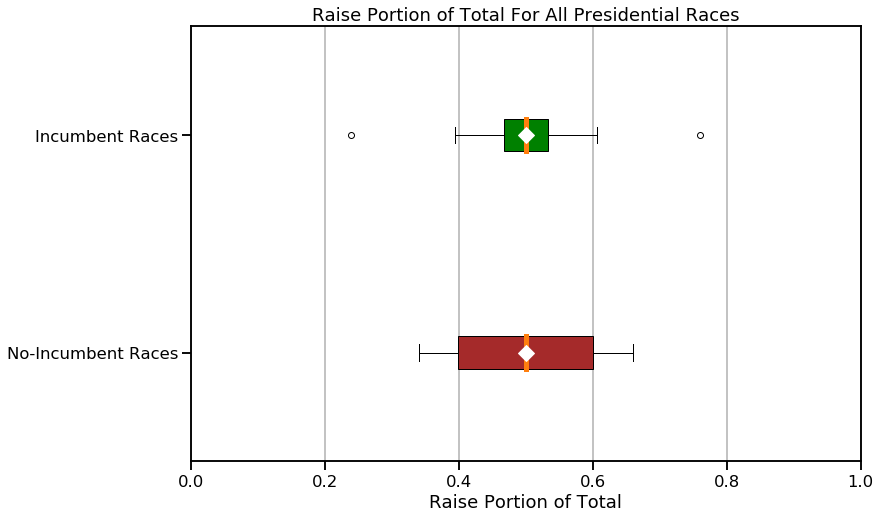

In [45]:
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([pres_no_inc['RaisedPortion'], pres_inc['RaisedPortion']],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['No-Incumbent Races', 'Incumbent Races'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)

box['boxes'][0].set_facecolor('brown')
box['boxes'][1].set_facecolor('green')

ax.set_xlabel('Raise Portion of Total')
ax.set_xlim([0, 1])
ax.set_title('Raise Portion of Total For All Presidential Races')
ax.grid(axis='x')
ax.set_axisbelow(True)


plt.show()

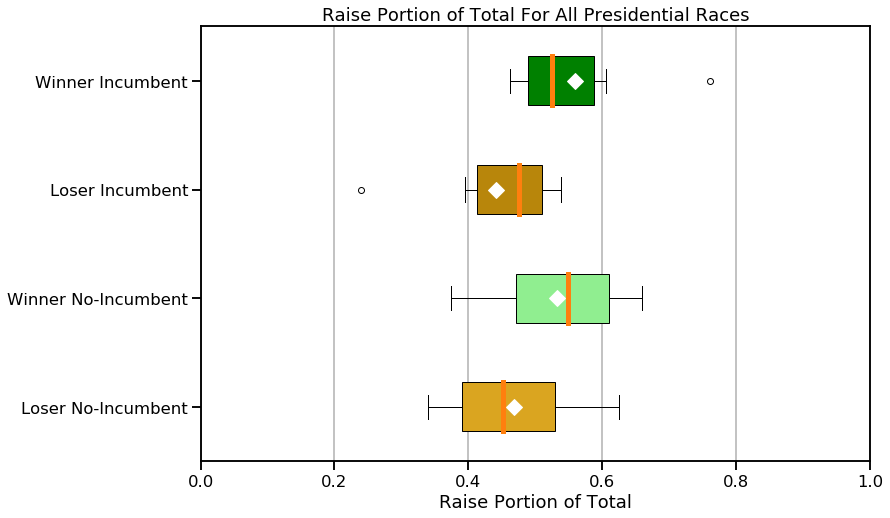

In [46]:
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([no_inc_won_0['RaisedPortion'], no_inc_won_1['RaisedPortion'],
                  inc_won_0['RaisedPortion'], inc_won_1['RaisedPortion']],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['Loser No-Incumbent', 'Winner No-Incumbent',
                         'Loser Incumbent', 'Winner Incumbent'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)
# named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
box['boxes'][0].set_facecolor('goldenrod')
box['boxes'][1].set_facecolor('lightgreen')
box['boxes'][2].set_facecolor('darkgoldenrod')
box['boxes'][3].set_facecolor('green')

ax.set_xlabel('Raise Portion of Total')
ax.set_xlim([0, 1])
ax.set_title('Raise Portion of Total For All Presidential Races')
ax.grid(axis='x')
ax.set_axisbelow(True)

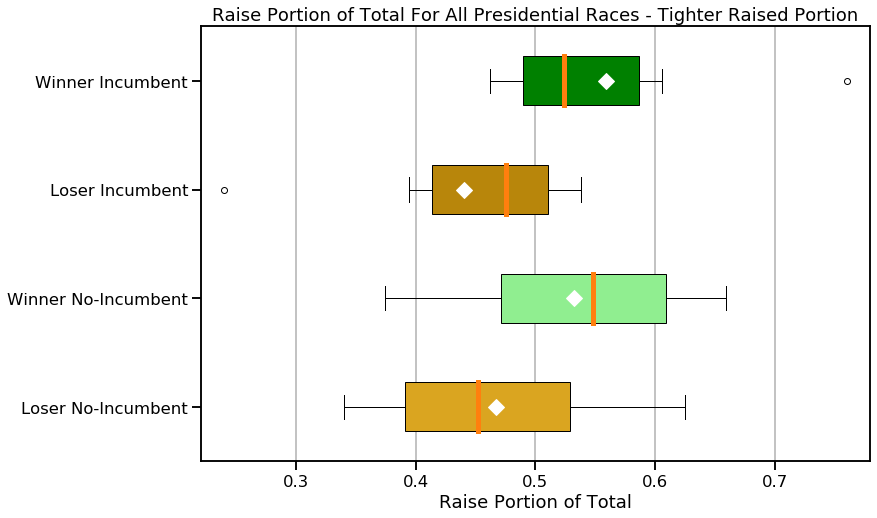

In [47]:
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([no_inc_won_0['RaisedPortion'], no_inc_won_1['RaisedPortion'],
                  inc_won_0['RaisedPortion'], inc_won_1['RaisedPortion']],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['Loser No-Incumbent', 'Winner No-Incumbent',
                         'Loser Incumbent', 'Winner Incumbent'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)
# named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
box['boxes'][0].set_facecolor('goldenrod')
box['boxes'][1].set_facecolor('lightgreen')
box['boxes'][2].set_facecolor('darkgoldenrod')
box['boxes'][3].set_facecolor('green')

ax.set_xlabel('Raise Portion of Total')
ax.set_xlim([0.22, 0.78])
ax.set_title('Raise Portion of Total For All Presidential Races - Tighter Raised Portion')
ax.grid(axis='x')
ax.set_axisbelow(True)

### Incumbent Vs. Incumbent

Winners look like they generally raise a higher portion of the total than loser regardless of the whether the race is between two non-incumbents or if there is an incumbent.  However, is there a difference between the two different types of races?

In [48]:
no_inc_won_0['RaisedPortion'].mean(), no_inc_won_1['RaisedPortion'].mean(), \
inc_won_0['RaisedPortion'].mean(), inc_won_1['RaisedPortion'].mean()

no_inc_delta = round(no_inc_won_1['RaisedPortion'].mean() - no_inc_won_0['RaisedPortion'].mean(), 4)
inc_delta = round(inc_won_1['RaisedPortion'].mean() - inc_won_0['RaisedPortion'].mean(), 4)

# no_inc_delta, inc_delta

msg1 = "No-Incumbent winner outraise their challengers by {} of the total raise".format(no_inc_delta)
msg2 = "Incumbent winner outraise their challengers by {} of the total raise".format(inc_delta)

inc_outraised = round(((inc_delta - no_inc_delta) * 100.) / no_inc_delta, 1)
# msg3 = "Inbumbent race winners outraise no-incumbent race winner by {}% on average".format(inc_outraised)
print(msg1)
print(msg2)
# print(msg3)

No-Incumbent winner outraise their challengers by 0.0652 of the total raise
Incumbent winner outraise their challengers by 0.1189 of the total raise


This is a large difference, but the sample size is very small so it may not be signficant.

### Senate Races

The senate race data is structured differently than the presidential data

The `CAND_ICI` column indicates whether a candidate was and incumbent (I) or a challenger (C).  If the value was missing, it generally meant the candidate was a challenger.

In [49]:
df_sen_fixed['CAND_ICI'] = df_sen_fixed['CAND_ICI'].fillna('C')
df_sen_fixed.head()

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName,CAND_NAME,CAND_ICI,TTL_RECEIPTS
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON,"DENTON, JEREMIAH A",C,648167.0
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM,"FOLSOM, JIM JR",C,228746.0
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI,"MURKOWSKI, FRANK H",C,527206.0
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING,"GRUENING, CLARK",C,512411.0
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER,"GOLDWATER, BARRY M",I,908342.0


In [50]:
# Find which races had more than more or less than 2 competitors.
# SQL Server ROW_NUMBER() window function equivalent
df_sen_fixed['rank'] = \
  df_sen_fixed.copy().groupby(['year', 'state'])['candidatevotes'].rank(method='first',
                                                                        ascending=False).astype(int)
df_sen_fixed.head()

,year,state_name,state,candidate,party_name,candidatevotes,totalvotes,Won,party,StripName,LastName,CAND_NAME,CAND_ICI,TTL_RECEIPTS,rank
0,1980,Alabama,AL,Jeremiah Denton,republican,650362,1296757,1,REP,Jeremiah Denton,DENTON,"DENTON, JEREMIAH A",C,648167.0,1
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,610175,1296757,0,DEM,Jim Folsom,FOLSOM,"FOLSOM, JIM JR",C,228746.0,2
2,1980,Alaska,AK,Frank H. Murkowski,republican,84159,156762,1,REP,Frank H. Murkowski,MURKOWSKI,"MURKOWSKI, FRANK H",C,527206.0,1
3,1980,Alaska,AK,Clark S. Gruening,democrat,72007,156762,0,DEM,Clark S. Gruening,GRUENING,"GRUENING, CLARK",C,512411.0,2
4,1980,Arizona,AZ,Barry Goldwater,republican,432371,874238,1,REP,Barry Goldwater,GOLDWATER,"GOLDWATER, BARRY M",I,908342.0,1


In [51]:
df_sen_qual = df_sen_fixed.copy().groupby(['year', 'state']).agg(
    race_ind = pd.NamedAgg(column='rank', aggfunc=sum),
    year_agg = pd.NamedAgg(column='year', aggfunc=min)
)

# df_sen_qual.drop('year', axis=1, inplace=True)
df_sen_qual[df_sen_qual['race_ind'] != 3]

,,race_ind,year_agg
year,state,,
1992,LA,1,1992
1996,AR,6,1996
2000,RI,6,2000
2004,AK,6,2004
2012,MA,6,2012


### More Manual Fixing

The 5 races above were manually fixed by:

+ 1992 LA, manually add Jon, Khachaturian data
+ 1996 AR, manually remove extra Y. Tim Hutchinson record
+ 2000 RI, manually remove extra Lincoln D. Chafee record
+ 2004 AK, manually remove extraneous Murkowski record
+ 2012 MA, manually remove extraneous Warren record

and the correct file saved as `df_sen_all_manually_fixed2.csv`

### Additional fixing

+ 2008 MS, removed this data (see below for details)
+ 2008 WY, removed this data (see below for details)

and the correct file saved as `df_sen_all_manually_fixed3.csv`

In [52]:
senate_data_path = senate_dir + 'df_sen_all_manually_fixed3.csv'
df_sen = pd.read_csv(senate_data_path)
df_sen.drop(['candidatevotes', 'totalvotes', 'party', 'StripName', 'LastName', 'CAND_NAME', 'Note'],
            axis=1, inplace=True)
# df_sen.shape  # should be an even number: (664, 14) --> check
df_sen.head()

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS
0,1980,Alabama,AL,Jeremiah Denton,republican,1,NaN,648167.0
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,NaN,228746.0
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,NaN,527206.0
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,NaN,512411.0
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.0


In [53]:
df_sen.shape

(664, 8)

### Remove races with one or both candidates missing financial data

In [54]:
sen_miss_fin = df_sen.copy().loc[df_sen['TTL_RECEIPTS'] < 0]
sen_miss_fin = sen_miss_fin.copy()[['year', 'state']]
sen_miss_fin['remove'] = True
# sen_miss_fin.shape  # (14, 2)
df_sen = df_sen.copy().merge(sen_miss_fin, how='left', on=['year', 'state'])
df_sen['remove'] = df_sen['remove'].replace(np.nan, False)
# df_sen_test[df_sen_test['remove']].shape  # (28, 9)
# df_sen_test[df_sen_test['remove']].head(4)
df_sen = df_sen.copy().loc[~df_sen['remove']]
df_sen.shape  # (664, 8) -> (636, 9) good, 28 records or 14 races removed

(636, 9)

### Add the TotalRaised and PortionRaised columns

In [55]:
df_sen_yr_state = df_sen.copy().groupby(['year', 'state']).agg(
    TotalRaised = pd.NamedAgg(column='TTL_RECEIPTS', aggfunc=sum)
)
df_sen_yr_state.head(6)

TotalRaised
year state             
1980 AK       1039617.0
     AL        876913.0
     AR        418586.0
     AZ       2838012.0
     CA       4305345.0
     CO       2173544.0

In [56]:
df_sen_mod = df_sen.merge(df_sen_yr_state, how='left', on=['year', 'state'])
df_sen_mod['RaisedPortion'] = df_sen_mod['TTL_RECEIPTS'] / df_sen_mod['TotalRaised']
# missing values in indicate that this was a challenger
df_sen_mod['CAND_ICI'] = df_sen_mod['CAND_ICI'].replace(np.nan, 'C')
df_sen_mod['isIncumbent'] = (df_sen_mod['CAND_ICI'] == 'I').astype(int)
df_sen_mod.head()

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS,remove,TotalRaised,RaisedPortion,isIncumbent
0,1980,Alabama,AL,Jeremiah Denton,republican,1,C,648167.0,False,876913.0,0.739146,0
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,C,228746.0,False,876913.0,0.260854,0
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,C,527206.0,False,1039617.0,0.507116,0
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,C,512411.0,False,1039617.0,0.492884,0
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.0,False,2838012.0,0.320063,1


In [57]:
df_sen_mod.shape

(636, 12)

### Portion Raised in Incumbent Vs. No-Incumbent Senate Races

To make this easier to analyze, start by adding a **isIncumbentRace** column.  Do this by identifying each race being incumbent or no-incumbent and then joining this identifier back to the main data.

In [58]:
df_sen_race_types = df_sen_mod.groupby(['year', 'state']).agg(
    isIncumbentRace = pd.NamedAgg(column='isIncumbent', aggfunc=sum)
)

# quality check - empty after removing  2008 MS, WY races which had special elections
# df_sen_race_types.shape  # (334, 1)
df_sen_race_types[df_sen_race_types['isIncumbentRace'] > 1]

,,isIncumbentRace
year,state,


In [59]:
df_sen_race_types.head()

isIncumbentRace
year state                 
1980 AK                   0
     AL                   0
     AR                   1
     AZ                   1
     CA                   1

### More manual fixing of the senate data

The 2008 MS and WY races had both a normal election and a special election that year.  Both of these of these races were removed from the data and the results stored in the file **df_sen_all_manually_fixed3.csv**

The next cell of commented out code was initially used, but the read in data file was fixed so this was neeeded anymore.

In [60]:
# df_sen_mod['remove'] = (((df_sen_mod['year'] == 2008) & (df_sen_mod['state'] == 'MS')) |
#                         ((df_sen_mod['year'] == 2008) & (df_sen_mod['state'] == 'WY')))
# df_sen_mod = df_sen_mod.copy()[~df_sen_mod['remove']]
# # df_sen_mod.shape  # 668 -> 664, the 4 records are removed
# df_sen_mod.drop('remove', axis=1, inplace=True)
# df_sen_mod.shape  # 18 columns -> 17

In [61]:
df_sen_mod.shape, df_sen_race_types.shape

((636, 12), (318, 1))

In [62]:
df_sen_mod = df_sen_mod.copy().merge(df_sen_race_types, how='left', on=['year', 'state'])
df_sen_mod.head()

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS,remove,TotalRaised,RaisedPortion,isIncumbent,isIncumbentRace
0,1980,Alabama,AL,Jeremiah Denton,republican,1,C,648167.0,False,876913.0,0.739146,0,0
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,C,228746.0,False,876913.0,0.260854,0,0
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,C,527206.0,False,1039617.0,0.507116,0,0
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,C,512411.0,False,1039617.0,0.492884,0,0
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.0,False,2838012.0,0.320063,1,1


In [63]:
# sen_inc_won_0.head()

In [64]:
# research question 1 wrt senate races
sen_all_no_inc = df_sen_mod.copy()[df_sen_mod['isIncumbentRace'] == 0]
sen_all_inc = df_sen_mod.copy()[df_sen_mod['isIncumbentRace'] == 1]

sen_all_no_inc.shape, sen_all_inc.shape  # ((138, 13), (498, 13))
# sen_all_no_inc.head(6)

((138, 13), (498, 13))

In [65]:
# break out no-incumbent senate races by win/lose in each race type
sen_no_inc_won_0 = sen_all_no_inc.copy()[sen_all_no_inc['Won'] == 0]
sen_no_inc_won_1 = sen_all_no_inc.copy()[sen_all_no_inc['Won'] == 1]

sen_no_inc_won_0.shape, sen_no_inc_won_1.shape  # ((69, 13), (69, 13)) looks good

((69, 13), (69, 13))

In [66]:
# break out incumbent senate races by win/lose in each race type
sen_inc_won_0 = sen_all_inc.copy()[sen_all_inc['Won'] == 0]
sen_inc_won_1 = sen_all_inc.copy()[sen_all_inc['Won'] == 1]

sen_inc_won_0.shape, sen_inc_won_1.shape  # ((249, 13), (249, 13)) check

((249, 13), (249, 13))

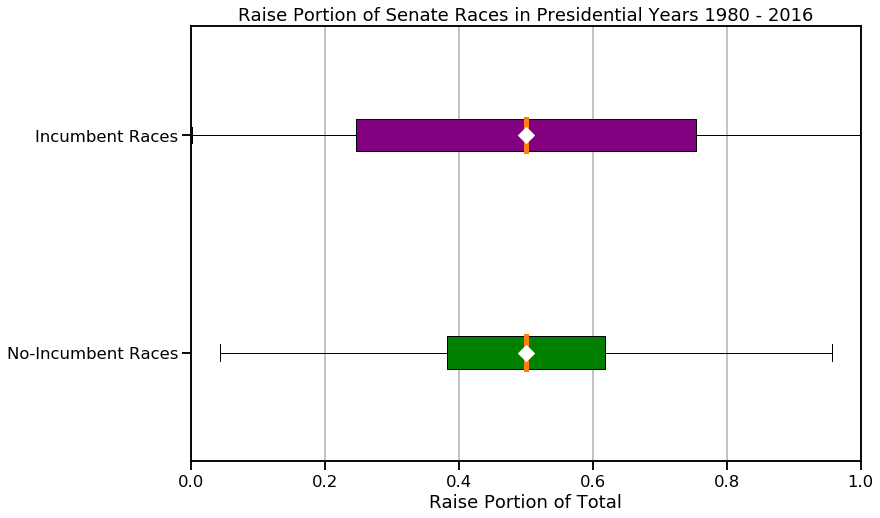

In [67]:
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([sen_all_no_inc['RaisedPortion'], sen_all_inc['RaisedPortion']],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['No-Incumbent Races', 'Incumbent Races'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)
# named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
box['boxes'][0].set_facecolor('green')
box['boxes'][1].set_facecolor('purple')

ax.set_xlabel('Raise Portion of Total')
ax.set_xlim([0, 1])
ax.set_title('Raise Portion of Senate Races in Presidential Years 1980 - 2016')
ax.grid(axis='x')
ax.set_axisbelow(True)

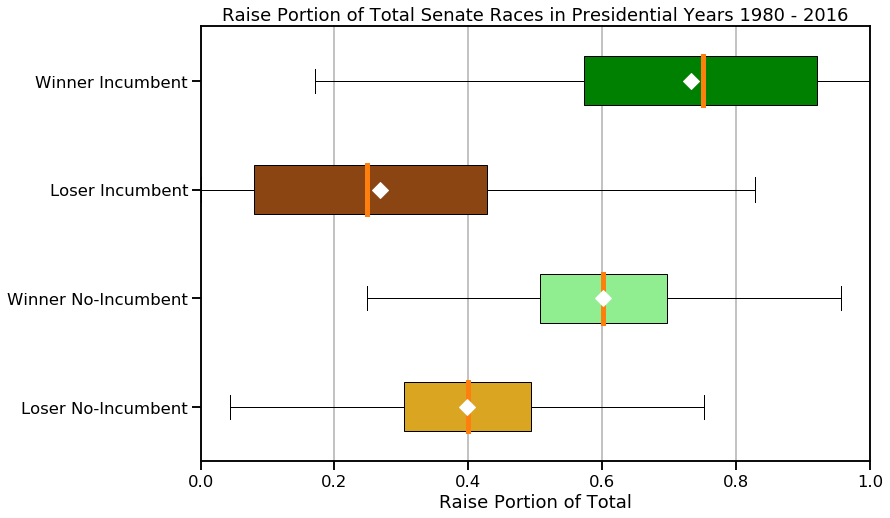

In [68]:
fig, ax = plt.subplots(figsize=(12,8))

meanpointprops = dict(marker='D', markersize=12,
                      markeredgecolor='white',
                      markerfacecolor='white')
medianprops = dict(linewidth = 5)

box = ax.boxplot([sen_no_inc_won_0['RaisedPortion'], sen_no_inc_won_1['RaisedPortion'],
                  sen_inc_won_0['RaisedPortion'], sen_inc_won_1['RaisedPortion']],
                 vert=False,
                 patch_artist=True,  # fill with color
                 showmeans = True,
                 labels=['Loser No-Incumbent', 'Winner No-Incumbent',
                         'Loser Incumbent', 'Winner Incumbent'],
                 medianprops=medianprops,
                 meanprops=meanpointprops)
# named colors: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
box['boxes'][0].set_facecolor('goldenrod')
box['boxes'][1].set_facecolor('lightgreen')
box['boxes'][2].set_facecolor('saddlebrown')
box['boxes'][3].set_facecolor('green')

ax.set_xlabel('Raise Portion of Total')
ax.set_xlim([0, 1])
ax.set_title('Raise Portion of Total Senate Races in Presidential Years 1980 - 2016')
ax.grid(axis='x')
ax.set_axisbelow(True)

### Model Senate Races

In [69]:
sen_form = 'Won ~ C(isIncumbent) + RaisedPortion'
sen_logitfit = smf.logit(formula = str(sen_form), data=df_sen_mod).fit()
sen_logitfit.summary()

Optimization terminated successfully.
         Current function value: 0.333187
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    Won   No. Observations:                  636
Model:                          Logit   Df Residuals:                      633
Method:                           MLE   Df Model:                            2
Date:                Mon, 09 Dec 2019   Pseudo R-squ.:                  0.5193
Time:                        21:53:50   Log-Likelihood:                -211.91
converged:                       True   LL-Null:                       -440.84
Covariance Type:            nonrobust   LLR p-value:                3.758e-100
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.0706      0.450    -11.259      0.000      -5.953      -4.188
C(isIncumbent)[T.1]     0.9503      0.277      3.432      0.001       0.408       1.493
RaisedPortion           9.5167      0.907     10.490      0.000       7.739      11.295
=======================================================================================
"""

### Senate Model Similar to Presidential Model

The logistic regression model for the senate races give remarkably similar results to the presidential races.  Happily, the p-values are all well below the $\alpha < 0.05$ threshold.  This is because there is so much more data for the senate races than there are for the presidential races.

In [70]:
# in-sample predictions
df_sen_mod['model_prob'] = logitfit.predict(df_sen_mod[['isIncumbent', 'RaisedPortion']])
df_sen_mod['e_mp'] = np.exp(df_sen_mod['model_prob'])
df_sen_mod.head()

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS,remove,TotalRaised,RaisedPortion,isIncumbent,isIncumbentRace,model_prob,e_mp
0,1980,Alabama,AL,Jeremiah Denton,republican,1,C,648167.0,False,876913.0,0.739146,0,0,0.909807,2.483843
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,C,228746.0,False,876913.0,0.260854,0,0,0.034958,1.035576
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,C,527206.0,False,1039617.0,0.507116,0,0,0.396608,1.486772
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,C,512411.0,False,1039617.0,0.492884,0,0,0.357297,1.429460
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.0,False,2838012.0,0.320063,1,1,0.238790,1.269712


In [71]:
# need to group by year and state for senate races
softmax_denom_sen = \
    df_sen_mod.groupby(['year', 'state']).agg(sum_e_mp = pd.NamedAgg(column='e_mp', aggfunc=sum))
softmax_denom_sen.head()

sum_e_mp
year state          
1980 AK     2.916233
     AL     3.519420
     AR     3.686062
     AZ     3.572276
     CA     3.687373

In [72]:
df_sen_probs = df_sen_mod.merge(softmax_denom_sen, how='left', on=['year', 'state'])
df_sen_probs['norm_probs'] = df_sen_probs['e_mp'] / df_sen_probs['sum_e_mp']
df_sen_probs['Won_Predict'] = (df_sen_probs['norm_probs'] > 0.5).astype(int)
df_sen_probs['Correct_Predict'] = (df_sen_probs['Won'] == df_sen_probs['Won_Predict']).astype(int)
df_sen_probs

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS,remove,TotalRaised,RaisedPortion,isIncumbent,isIncumbentRace,model_prob,e_mp,sum_e_mp,norm_probs,Won_Predict,Correct_Predict
0,1980,Alabama,AL,Jeremiah Denton,republican,1,C,648167.00,False,876913.00,0.739146,0,0,0.909807,2.483843,3.519420,0.705754,1,1
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,C,228746.00,False,876913.00,0.260854,0,0,0.034958,1.035576,3.519420,0.294246,0,1
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,C,527206.00,False,1039617.00,0.507116,0,0,0.396608,1.486772,2.916233,0.509826,1,1
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,C,512411.00,False,1039617.00,0.492884,0,0,0.357297,1.429460,2.916233,0.490174,0,1
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.00,False,2838012.00,0.320063,1,1,0.238790,1.269712,3.572276,0.355435,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,2016,Vermont,VT,Scott Milne,republican,0,C,127633.00,False,4058525.11,0.031448,0,1,0.002429,1.002432,3.716525,0.269723,0,1
632,2016,Washington,WA,Patty Murray,democrat,1,I,10176110.19,False,10621479.19,0.958069,1,1,0.998256,2.713545,3.716295,0.730175,1,1
633,2016,Washington,WA,Chris Vance,republican,0,C,445369.00,False,10621479.19,0.041931,0,1,0.002747,1.002750,3.716295,0.269825,0,1
634,2016,Wisconsin,WI,Ron Johnson,republican,1,I,17683385.71,False,42540556.71,0.415683,1,1,0.491521,1.634802,3.493493,0.467956,0,0


In [73]:
sen_model_accuracy = df_sen_probs['Correct_Predict'].sum() / df_sen_probs.shape[0]
msg_sen = 'In Sample Model Senate Race Prediction Accuracy = {}'.format(sen_model_accuracy)
print(msg_sen)

In Sample Model Senate Race Prediction Accuracy = 0.8522012578616353


### Senate model shows better in-sample accuracy than Presidential model

Senate in-sample accuracy > 85% vs. Presidential in-sample accuracy of 80%.

### Add Historical Senate Campaign Raises to Presidential Plot

In [74]:
df_sen_mod.head()

,year,state_name,state,candidate,party_name,Won,CAND_ICI,TTL_RECEIPTS,remove,TotalRaised,RaisedPortion,isIncumbent,isIncumbentRace,model_prob,e_mp
0,1980,Alabama,AL,Jeremiah Denton,republican,1,C,648167.0,False,876913.0,0.739146,0,0,0.909807,2.483843
1,1980,Alabama,AL,Jim Folsom Jr.,democrat,0,C,228746.0,False,876913.0,0.260854,0,0,0.034958,1.035576
2,1980,Alaska,AK,Frank H. Murkowski,republican,1,C,527206.0,False,1039617.0,0.507116,0,0,0.396608,1.486772
3,1980,Alaska,AK,Clark S. Gruening,democrat,0,C,512411.0,False,1039617.0,0.492884,0,0,0.357297,1.429460
4,1980,Arizona,AZ,Barry Goldwater,republican,1,I,908342.0,False,2838012.0,0.320063,1,1,0.238790,1.269712


In [75]:
df_sen_yr_hist = df_sen_mod.groupby('year').agg(
    sum_sen_yr = pd.NamedAgg(column='TTL_RECEIPTS', aggfunc=sum)
)

df_sen_yr_hist['sum_sen_yr'] = df_sen_yr_hist['sum_sen_yr'] / 1e09
df_sen_yr_hist

,sum_sen_yr
year,
1980,0.069235
1984,0.143039
1988,0.183349
1992,0.175145
1996,0.219621
2000,0.382415
2004,0.373985
2008,0.364294
2012,0.582175


In [76]:
x_line = np.arange(1980, 2017, 4)
y_line = 100 * x_line
y_line

array([198000, 198400, 198800, 199200, 199600, 200000, 200400, 200800,
       201200, 201600])

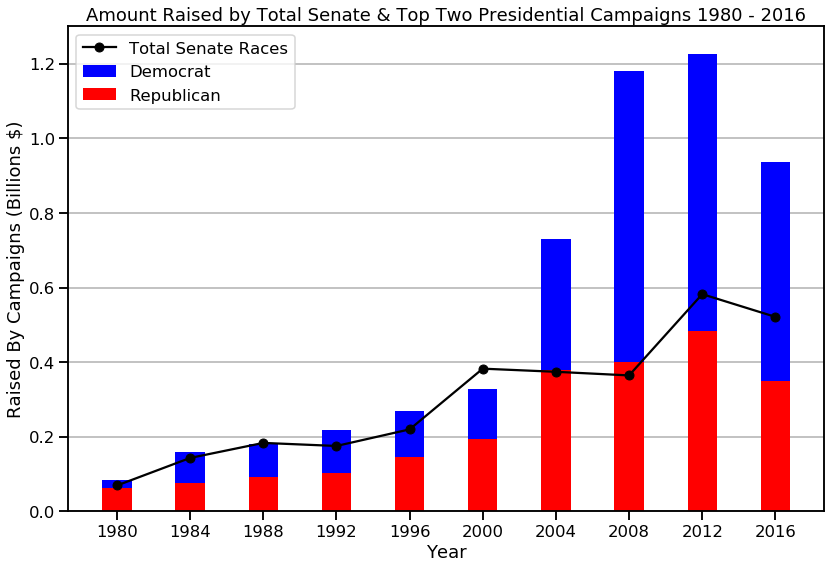

In [77]:
# parameterize the y axis max
y_max_axis = 1.3

# grouped bar charts: https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
fig, ax = plt.subplots(figsize=(12,8))
# fig, ax = plt.subplots()
# left_bar = ax.bar(x_ind - bar_width/2, dem_raise, bar_width, label='Democrat')
# right_bar = ax.bar(x_ind + bar_width/2, rep_raise, bar_width, label='Republican')
# dem_bar = ax.bar(x_ind, dem_raise, bar_width,
#                  color='blue', label='Democrat')
dem_bar = ax.bar(x_ind, dem_raise, bar_width,
                 bottom=rep_raise, color='blue', label='Democrat')
rep_bar = ax.bar(x_ind, rep_raise, bar_width,
                 color='red', label='Republican')
ax.plot(x_ind, df_sen_yr_hist['sum_sen_yr'], color='k', marker='o', label='Total Senate Races')

ax.set_ylabel('Raised By Campaigns (Billions $)')
ax.set_ylim(0, y_max_axis)
ax.set_xlabel('Year')
ax.set_title('Amount Raised by Total Senate & Top Two Presidential Campaigns 1980 - 2016')
ax.set_xticks(x_ind)
ax.set_xticklabels(df_pres_overall.index)
ax.grid(axis='y')
# put grid below the plotted bars
ax.set_axisbelow(True)

fig.tight_layout()

ax.legend(loc='upper left')


plt.show()

### TODO Items

+ Add 

### Date Sources

First 8 columns of presidential finance and election spreadsheet:  
https://www.fec.gov/data/raising-bythenumbers/

Columns 9 and 10 of the presidential finance and election spreadsheet:  
https://www.britannica.com/topic/United-States-Presidential-Election-Results-1788863

Historical US Senate election (see description provided near the top of the notebook):  
http://electionlab.mit.edu/
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PEJ5QU

State-Level US Presidential Campaign Finance Data:  
https://www.fec.gov/data/raising-bythenumbers/


### Reference

1984 United States Senate election in Louisiana - https://en.wikipedia.org/wiki/1984_United_States_Senate_election_in_Louisiana

2004 United States Senate election in Idaho - https://en.wikipedia.org/wiki/2004_United_States_Senate_election_in_Idaho

SQL window function equivalents in pandas:  
https://dfrieds.com/data-analysis/rank-method-python-pandas  
https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe

grouped bar charts - https://www.pythoncharts.com/2019/03/26/grouped-bar-charts-matplotlib/

Annotating Plots - https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/annotation_demo.html

T-Test in python - https://scientificallysound.org/2017/05/16/independent-t-test-python/

Horizontal box plots - http://www.datasciencemadesimple.com/box-plot-in-python/

Logistic Regression with statsmodels using the formula interface:
http://songhuiming.github.io/pages/2016/07/12/statsmodels-regression-examples/

Softmax Function:  
https://en.wikipedia.org/wiki/Softmax_function